In [1]:
import ase
from util_funcs import AtomsToGraphs, edge_feat
import util_funcs
from torch_geometric.utils import to_networkx, from_networkx, degree
import numpy as np
import os
import torch
from torch_geometric.data import Data
from torch import scatter 
from torch.nn import Linear
from torch import nn
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, DenseSAGEConv, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import ceil
from embeddings import CONTINUOUS_EMBEDDINGS as c_embd, ATOMIC_RADII as a_rad
import basis_func
from model import GNet, MAELoss

#from torch_geometric.data import DataLoader
#from torch_geometric.nn import DenseSAGEConv, dense_diff_pool

In [2]:
a2g = AtomsToGraphs(
    max_neigh=200,
    radius= 6,
    r_energy=True,
    r_forces=True,
    r_distances=True,
    r_edges=True,
    r_fixed=True,
)
"""
for i in range(0,40):
    parent_dir = os.getcwd()+f"/s2ef_train_200K/{i}.extxyz"
    raw_data = ase.io.read(loc, ':')
    #processed_dir = os.getcwd()+ "/preprocessed_dir/" + "_"+str(i)+"_"
    
    #data_0 = raw_data
    path = os.getcwd() + "/preprocessed_dir/" + str(i)
    processed_dir = os.makedirs(path, exist_ok= True)
    
    
    graph_data = a2g.convert_all(raw_data, 
                                processed_file_path = path,
                                collate_and_save = True)
"""

'\nfor i in range(0,40):\n    parent_dir = os.getcwd()+f"/s2ef_train_200K/{i}.extxyz"\n    raw_data = ase.io.read(loc, \':\')\n    #processed_dir = os.getcwd()+ "/preprocessed_dir/" + "_"+str(i)+"_"\n    \n    #data_0 = raw_data\n    path = os.getcwd() + "/preprocessed_dir/" + str(i)\n    processed_dir = os.makedirs(path, exist_ok= True)\n    \n    \n    graph_data = a2g.convert_all(raw_data, \n                                processed_file_path = path,\n                                collate_and_save = True)\n'

In [3]:
data = [torch.load(os.getcwd()+f"/preprocessed_dir/0/data_{i}.pt") for i in tqdm(range(0,5000))]

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:57<00:00, 42.38it/s]


In [4]:
len(data)

5000

In [7]:
# Converting PyG Graph into networkx graph to make a animates plot
i = 100
g_1 = to_networkx(data[i], node_attrs= ["pos","atomic_numbers", "force", "x" ],
                  edge_attrs= ["distx", "cell_offsets"])
data[i]

Data(pos=[80, 3], cell=[1, 3, 3], atomic_numbers=[80], atomic_masses=[80], natoms=80, edge_index=[2, 2304], cell_offsets=[2304, 3], y=-384.83190381, force=[80, 3], distances=[2304], tags=[80], fixed=[80], x=[80, 14], distx=[2304])

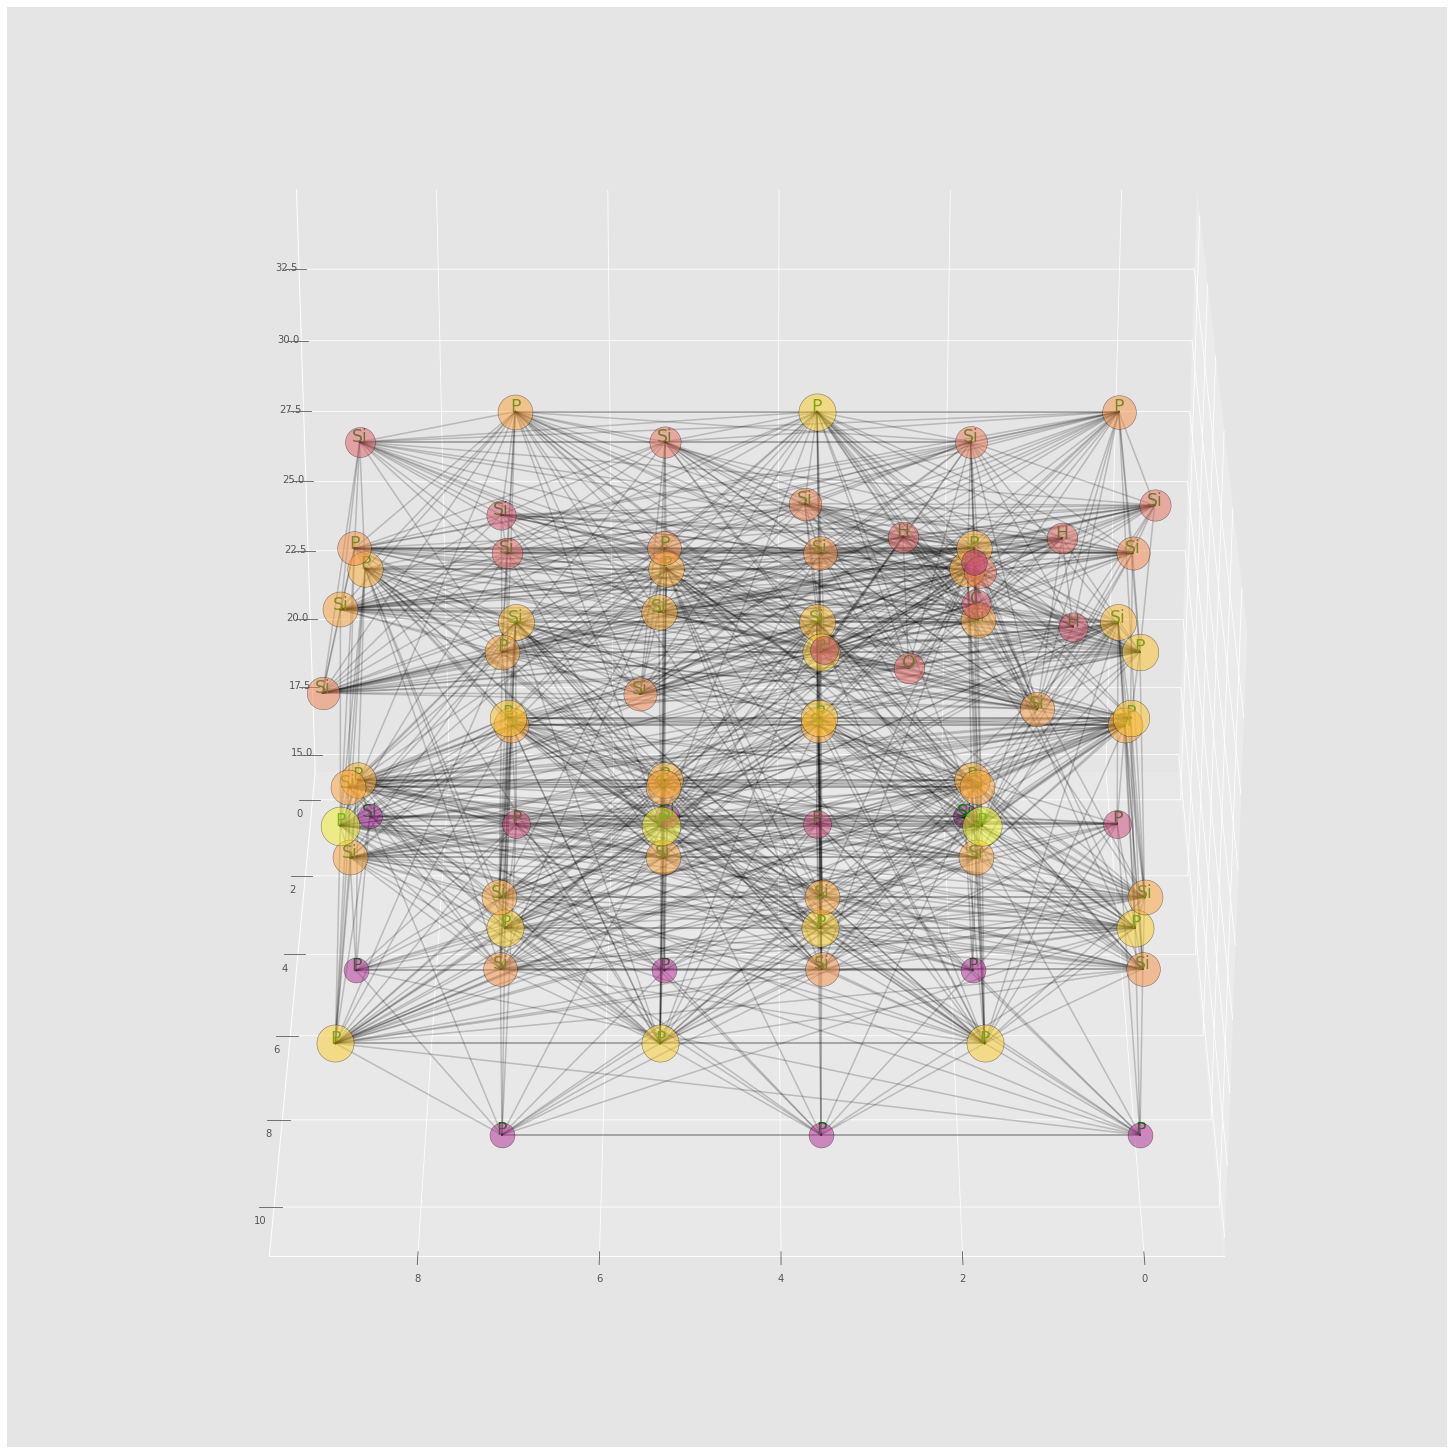

In [8]:
util_funcs.network_plot_3D(g_1, 90, save=False)

In [7]:
"""
model = GNet(embedding_size = 512)

print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
"""

'\nmodel = GNet(embedding_size = 512)\n\nprint(model)\nprint("Number of parameters: ", sum(p.numel() for p in model.parameters()))\n'

In [8]:
torch.cuda.empty_cache()

In [9]:
"""
from torch_geometric.loader import DataLoader
import warnings
#warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = MAELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(graph_data)
NUM_GRAPHS_PER_BATCH = 64

loader = DataLoader(graph_data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
#test_loader = DataLoader(graph_data[int(data_size * 0.8):], 
#                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch)
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, batch.y))
        #loss = ((pred - batch.y).pow(2)).mean()
        loss.backward()
        #total_loss = 0
        #total_loss += loss.item() * batch.num_graphs
        # Update using the gradients
        optimizer.step()
    return loss

print("Starting training...")
losses = []
for epoch in tqdm(range(1000)):
    loss = train(graph_data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")
"""

'\nfrom torch_geometric.loader import DataLoader\nimport warnings\n#warnings.filterwarnings("ignore")\n\n# Root mean squared error\nloss_fn = MAELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.0001)\n\n# Use GPU for training\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = model.to(device)\n\n# Wrap data in a data loader\ndata_size = len(graph_data)\nNUM_GRAPHS_PER_BATCH = 64\n\nloader = DataLoader(graph_data[:int(data_size * 0.8)], \n                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)\n#test_loader = DataLoader(graph_data[int(data_size * 0.8):], \n#                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)\n\ndef train(data):\n    # Enumerate over the data\n    for batch in loader:\n        # Use GPU\n        batch.to(device)\n        # Reset gradients\n        optimizer.zero_grad()\n        # Passing the node features and the connection info\n        pred = model(batch)\n        # Calculating the loss and grad

In [10]:
#losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
#loss_indices = [i for i,l in enumerate(losses_float)]
#pt = plt.plot(loss_indices, losses_float)
#plt.plot(loss_indices, losses_float)

In [13]:
from torch_geometric.loader import DataLoader
import warnings
#warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = MAELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(graph_data)
NUM_GRAPHS_PER_BATCH = 16

loader = DataLoader(graph_data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
#test_loader = DataLoader(graph_data[int(data_size * 0.8):], 
#                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch)
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, batch.y))
        #loss = ((pred - batch.y).pow(2)).mean()
        loss.backward()
        #total_loss = 0
        #total_loss += loss.item() * batch.num_graphs
        # Update using the gradients
        optimizer.step()
    return loss

print("Starting training...")
losses = []
for epoch in tqdm(range(5000)):
    loss = train(graph_data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...


  0%|                                                                            | 1/5000 [02:03<171:30:43, 123.51s/it]

Epoch 0 | Train Loss 33.39366916369223


  2%|█▌                                                                           | 101/5000 [09:59<6:33:01,  4.81s/it]

Epoch 100 | Train Loss 29.45585007848566


  4%|███                                                                          | 201/5000 [18:00<6:27:37,  4.85s/it]

Epoch 200 | Train Loss 31.95100834127274


  6%|████▋                                                                        | 301/5000 [26:01<6:23:10,  4.89s/it]

Epoch 300 | Train Loss 33.29812601736954


  8%|██████▏                                                                      | 401/5000 [33:30<5:38:15,  4.41s/it]

Epoch 400 | Train Loss 40.14466203601445


  9%|██████▌                                                                      | 427/5000 [35:27<6:19:48,  4.98s/it]


KeyboardInterrupt: 